**Business Understanding**

In [ ]:
#Load data 
#scale, resize the images
#Inspect some of the images
#display the Image classes

# Loading the Data

In [16]:
#Importing libraries
import numpy as np
import pandas as pd
from PIL import Image
import hashlib
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array,load_img
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
#Loading the data

#Defining the main folder with subfolders for each class
folder_path='vehicles'

#creating an image data generator with rescaling
datagen=ImageDataGenerator(rescale=1./255)

#Loading the images from the different folders

image_data=datagen.flow_from_directory(folder_path,target_size=(224,224),batch_size=32,class_mode='categorical')

#Displaying the class labels and their indices

print(image_data.class_indices)


Found 5567 images belonging to 7 classes.
{'Auto Rickshaws': 0, 'Bikes': 1, 'Cars': 2, 'Motorcycles': 3, 'Planes': 4, 'Ships': 5, 'Trains': 6}


The dataset comprises a total of 5,587 images distributed across 7 classes. Each class has been assigned a unique label and corresponding index: Auto Rickshaws (0), Bikes (1), Cars (2), Motorcycles (3), Planes (4), Ships (5), and Trains (6).

# Data Cleaning

1.  Checking for corrupt images

In [13]:
#Checking for corrupt images

# Dictionary to store counts per class
corrupt_images = {}  

# Counter for total corrupt images
total_corrupt = 0  

# Looping through class subfolders
for category in os.listdir(folder_path):  
    class_path = os.path.join(folder_path, category)
    
#skipping non-folder files
    
    if not os.path.isdir(class_path):  
        continue

    corrupt_count = 0 
    
#Looping through images in class   
    for img_name in os.listdir(class_path):  
        img_path = os.path.join(class_path, img_name)

#Try opening an image and check if it's valid
        try:
            img = Image.open(img_path) 
            img.verify()  
        except Exception as e:
            corrupt_count += 1  
            total_corrupt += 1  
            print(f"Corrupt image found in {category}: {img_path} - {e}")

    if corrupt_count > 0:
        corrupt_images[category] = corrupt_count  

# Printing the corrupt images
print("\nSummary of Corrupt Images:")
for category, count in corrupt_images.items():
    corrupt_images= print(f"{category}: {count} corrupt images")

print(f"\nTotal corrupt images found: {total_corrupt}")


Summary of Corrupt Images:

Total corrupt images found: 0


**Interpretation**

The dataset contains some corrupted images, including 20 from the Auto Rickshaws class and 2 from the Planes class, resulting in a total of 22 corrupted images.

In [5]:
#Deleting the corrupt Images

# Counter for total corrupt images
total_corrupt = 0  

# Looping through class subfolders
for category in os.listdir(folder_path):  
    class_path = os.path.join(folder_path, category)
    
    if not os.path.isdir(class_path):  
        continue
        
#Looping through images in class
    for img_name in os.listdir(class_path):  
        img_path = os.path.join(class_path, img_name)
        
#Try opening the image and checking if it's valid
        try:
            img = Image.open(img_path)  
            img.verify() 
        except Exception as e:
            total_corrupt += 1  
            print(f"Deleting corrupt image: {img_path} - {e}")
            os.remove(img_path)  # Deleting the corrupt image

# Print final count of deleted images
print(f"\nTotal corrupt images deleted: {total_corrupt}")



Total corrupt images deleted: 0


# Exploratory Data Analysis

**1. To visually inspect some Images**

Shape of batch: (32, 224, 224, 3)


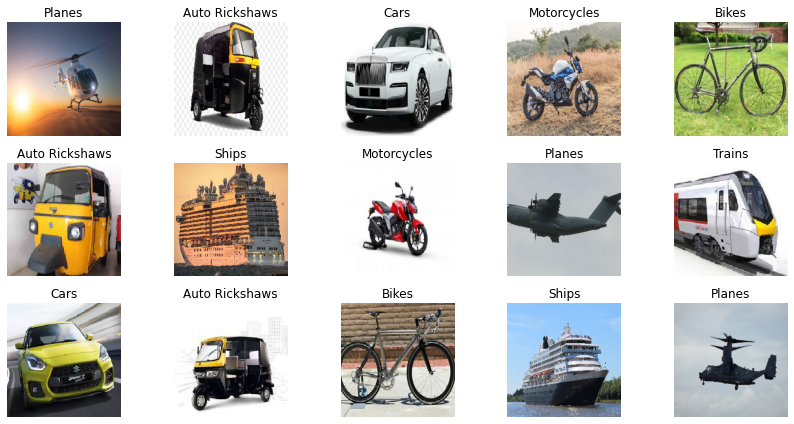

In [35]:
# Getting a batch of images and label
images, labels = next(image_data) 

# Checking the shape of the entire batch
print("Shape of batch:", images.shape)

# Plotting a few sample images
num_images = 15
plt.figure(figsize=(12, 6))

for i in range(num_images):
    plt.subplot(3,5, i + 1)
    plt.imshow(images[i])  
    plt.axis("off")
    
     # Getting the class index
    class_index = np.argmax(labels[i]) 
    
    # Getting the class name from the indices
    class_name = list(image_data.class_indices.keys())[class_index]
    
    #Display the class name for each Image
    plt.title(class_name)  

plt.tight_layout()
plt.show()

**Interpretation**

The displayed images appear well-classified, meaning that each image correctly belongs to its respective category. The class labels align with the visuals, ensuring accurate labeling. The images also have a height and width of 224 pixels and are RGB, meaning they are colored images.

**2. To display the Images per class**

In [15]:
# Dictionary to store counts per class
remaining_images = {}

# Loop through class subfolders
for category in os.listdir(folder_path):
    class_path = os.path.join(folder_path, category)
    
    if os.path.isdir(class_path):  
        remaining_images[category] = len(os.listdir(class_path))

# Print summary of remaining images
print("\nRemaining Images per Class:")
for category, count in remaining_images.items():
    print(f"{category}: {count} images remaining")



Remaining Images per Class:
Auto Rickshaws: 780 images remaining
Bikes: 800 images remaining
Cars: 790 images remaining
Motorcycles: 800 images remaining
Planes: 798 images remaining
Ships: 800 images remaining
Trains: 800 images remaining


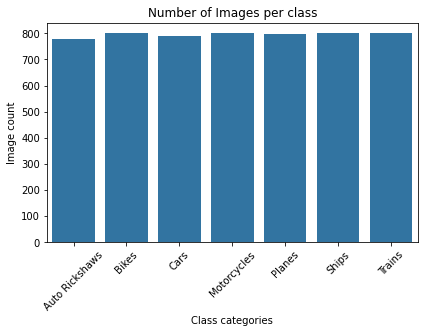

In [21]:
#Displaying the Images per class
plt. figure()

# Extracting class names and counts
categories = list(remaining_images.keys())
counts = list(remaining_images.values())

#Creating a barplot
sns.barplot(x=categories,y=counts)

plt.title('Number of Images per class')
plt.xlabel('Class categories')
plt.ylabel('Image count')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

**Interpretation**

The dataset is already fairly balanced, with each class having between 780 and 800 images. The small differences (±20 images) are not significant enough to cause major class imbalance issues.

# Modeling

### Data Preprocessing

**Creating folders for train, validation and test splits**

In [ ]:
# Define paths
#Folder where train, validation and test sets will be created.
split_path = 'split'  

# Defining split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Creating new folders
for split in ['train', 'validation', 'test']:
    os.makedirs(os.path.join(split_path, split), exist_ok=True)

# Splitting the images
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        random.shuffle(images)

        # Computing split indices
        total_images = len(images)
        train_split = int(total_images * train_ratio)
        val_split = train_split + int(total_images * val_ratio)

        # Creating subfolders
        for split in ['train', 'validation', 'test']:
            os.makedirs(os.path.join(split_path, split, category), exist_ok=True)

        # Moving images into corresponding folders
        for i, img in enumerate(images):
            src_path = os.path.join(category_path, img)

            if i < train_split:
                dst_path = os.path.join(split_path, 'train', category, img)
            elif i < val_split:
                dst_path = os.path.join(split_path, 'validation', category, img)
            else:
                dst_path = os.path.join(split_path, 'test', category, img)

            shutil.move(src_path, dst_path)

print("Dataset split into train, validation, and test sets!")

**Loading data from the different splits**

In [ ]:
# Defining paths for train, validation, and test
train_dir = os.path.join(split_path, 'train')
val_dir = os.path.join(split_path, 'validation')
test_dir = os.path.join(split_path, 'test')

# Loading the data for each split
print('Training data:')
train_data = datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
print('validation data:')
val_data = datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
print('Test data:')
test_data = datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='categorical')

After splitting the data, the dataset consists of 3,897 training images, 834 validation images, and 836 test images, maintaining a 70% training, 15% validation, and 15% test ratio.